- [17.2 - Robust Linear Regression](#17.2---Robust-Linear-Regression)

## Chapter 17 - Metric-Predicted Variable with One Metric Predictor

In [1]:
# %load ../../standard_import.txt
import pandas as pd
import numpy as np
import pymc3 as pmc
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import gridspec
from sklearn import preprocessing
from scipy.stats import mode, norm, t

pd.set_option('display.notebook_repr_html', False)

#%config InlineBackend.figure_formats = {'pdf',}
%matplotlib inline
plt.style.use('seaborn-white')

color = '#87ceeb'
burnin = 25

f_dict = {'size':16}


In [2]:
# Below function takes an array as input.

def plot_posterior(dist, decimals=3, vert_ref=None, alpha=0.05, y_labels=False, ax=None):
       
    color = '#87ceeb'
    
    if ax == None:
        ax = plt.gca()
    
    ax_mode = mode(np.round(dist, decimals=decimals))[0][0] 
    hpd_interval = np.round(pmc.hpd(dist, alpha=alpha), decimals=decimals)

    # Histogram, Mode
    sns.distplot(dist, kde=False, color=color, ax=ax)
    plot_height = ax.get_ylim()[1]
    ax.text(ax_mode, plot_height*.9, 'mode = {}'.format(ax_mode),
            horizontalalignment='center', fontdict={'size':14})    

    # HPD interval
    ax.hlines(ax.get_ylim()[1]*0.01, *hpd_interval, linewidth=4)
    for interval_point in hpd_interval:
        ax.text(interval_point, plot_height*0.05, interval_point,
                horizontalalignment='center', fontdict={'size':14})
    ax.text(np.mean(hpd_interval), plot_height*0.13, '{}% HPD'.format((1-alpha)*100),
            horizontalalignment='center', fontdict={'size':14})

    # Reference line
    if vert_ref is None:
        ax.axvline(ax_mode, color='g', linestyle='dotted')
    else:
        ax.axvline(vert_ref, color='g', linestyle='dotted')

    # Set labels and axis
    if y_labels is False:
        ax.yaxis.set_visible(False)
        ax.spines['left'].set_visible(False)
    [ax.spines[spine].set_visible(False) for spine in ['right', 'top']]
    
    return(ax)

### Data

In [3]:
df_n30 = pd.read_csv('data/HtWtData30.csv')
df_n30.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 3 columns):
male      30 non-null int64
height    30 non-null float64
weight    30 non-null float64
dtypes: float64(2), int64(1)
memory usage: 800.0 bytes


In [4]:
df_n30.head()

   male  height  weight
0     0    64.0   136.4
1     0    62.3   215.1
2     1    67.9   173.6
3     0    64.2   117.3
4     0    64.8   123.3

In [23]:
# Using Scikit-learn to standardize the data.
# The StandardScaler objects will have the attributes scale_ and mean_ which we can 
# use to transform the model parameter back to original scale.

scaler_h = preprocessing.StandardScaler().fit(df_n30.height.reshape(-1,1))
zheight = scaler_h.transform(df_n30.height.reshape(-1,1))
sd_h = scaler_h.scale_
mean_h = scaler_h.mean_

scaler_w = preprocessing.StandardScaler().fit(df_n30.weight.reshape(-1,1))
zweight = scaler_w.transform(df_n30.weight.reshape(-1,1))
sd_w = scaler_w.scale_
mean_w = scaler_w.mean_

### 17.2 - Robust Linear Regression

#### Model

In [11]:
with pmc.Model() as model:
    
    beta0 = pmc.Normal('beta0', mu=0, tau=1/10**2)
    beta1 = pmc.Normal('beta1', mu=0, tau=1/10**2)
    mu =  beta0 + beta1*zheight.ravel()
    
    sigma = pmc.Uniform('sigma', 10**-3, 10**3)
    nu = pmc.Exponential('nu', 1/29)
    
    likelihood = pmc.StudentT('likelihood', nu, mu=mu, sd=sigma, observed=zweight.ravel())

Applied interval-transform to sigma and added transformed sigma_interval_ to model.
Applied log-transform to nu and added transformed nu_log_ to model.


In [25]:
with model:
    trace = pmc.sample(10000)

Assigned NUTS to beta0
Assigned NUTS to beta1
Assigned NUTS to sigma_interval_
Assigned NUTS to nu_log_
 [-----------------100%-----------------] 10000 of 10000 complete in 406.1 sec

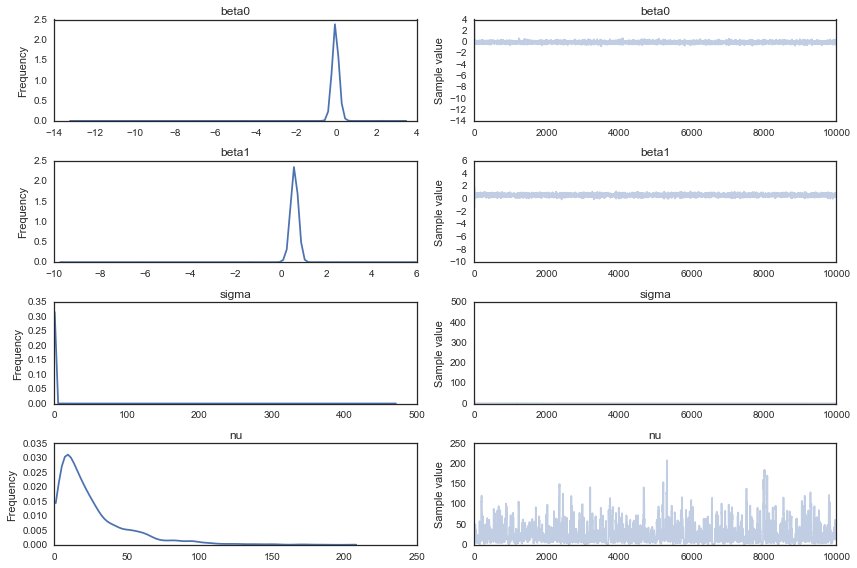

In [26]:
pmc.traceplot(trace);

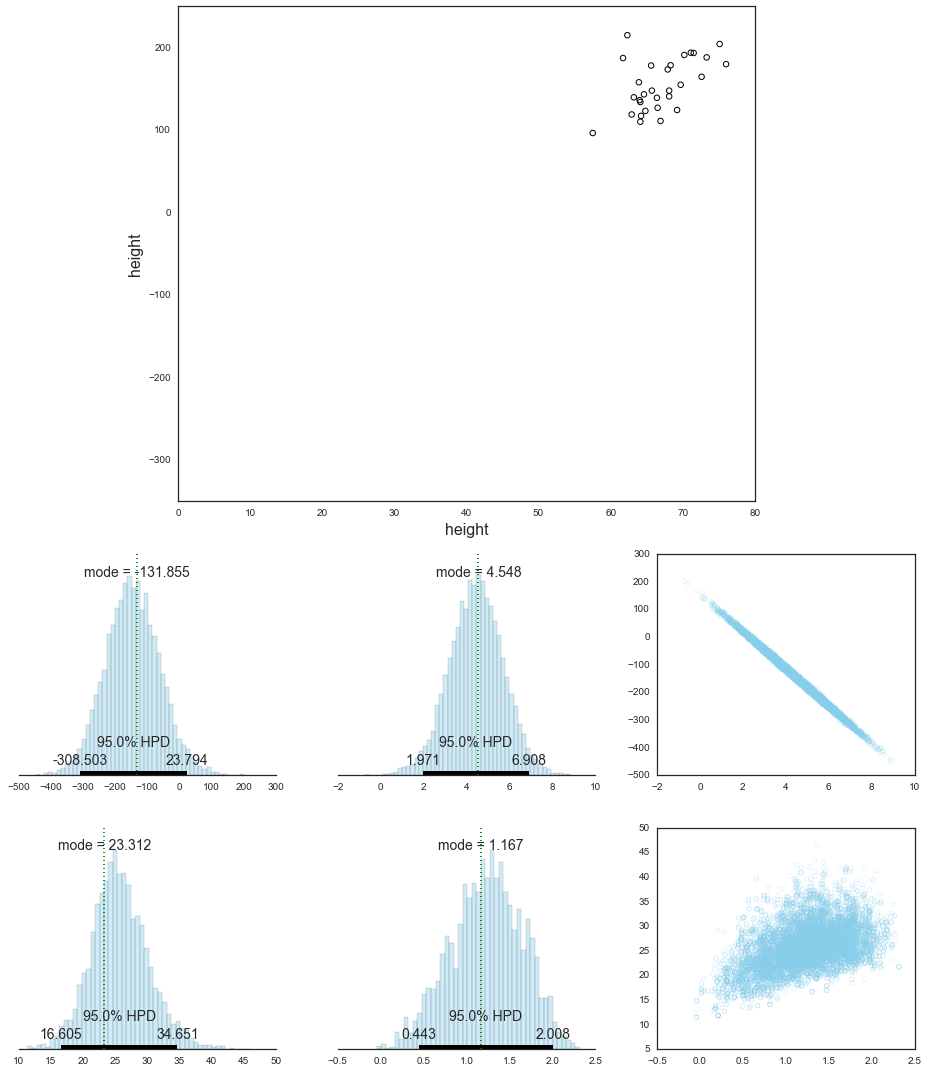

In [34]:
plt.figure(figsize=(13,15))

# Define gridspec
gs = gridspec.GridSpec(4, 6)
ax1 = plt.subplot(gs[:2,1:5])
ax2 = plt.subplot(gs[2,:2])
ax3 = plt.subplot(gs[2,2:4])
ax4 = plt.subplot(gs[2,4:6])
ax5 = plt.subplot(gs[3,:2])
ax6 = plt.subplot(gs[3,2:4])                     
ax7 = plt.subplot(gs[3,4:6])

# Scatter plot observed data
ax1.scatter(df_n30.height, df_n30.weight, s=30, linewidths=1, facecolor='none')
ax1.set_xlabel('height', fontdict=f_dict)
ax1.set_ylabel('height', fontdict=f_dict)
ax1.set(xlim=(0,80), ylim=(-350,250))

# Intercept
plot_posterior(trace['beta0'][burnin:]*sd_w+mean_w-trace['beta1'][burnin:]*mean_h*sd_w/sd_h, ax=ax2)

# Slope
plot_posterior(trace['beta1'][burnin:]*(sd_w/sd_h), ax=ax3)

# Scatter plot beta1, beta0
ax4.scatter(trace['beta1'][burnin:]*(sd_w/sd_h),
            trace['beta0'][burnin:]*sd_w+mean_w-trace['beta1'][burnin:]*mean_h*sd_w/sd_h,
           edgecolor=color, facecolor='none', alpha=.6)

# Scale
plot_posterior(trace['sigma'][burnin:]*sd_w, ax=ax5)

# Normality
plot_posterior(np.log10(trace['nu'][burnin:]), ax=ax6)

# Scatter plot normality, sigma
ax7.scatter(np.log10(trace['nu'][burnin:]), trace['sigma'][burnin:]*sd_w,
            edgecolor=color, facecolor='none', alpha=.6)

plt.tight_layout();